### This jupyter notebooks provides the code for classifying signals using the Continuous Wavelet Transform and Convolutional Neural Networks.
### To get some more background information, please have a look at the accompanying blog-post:
### http://ataspinar.com

In [1]:
import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.fftpack import fft
from IPython.display import display

import matplotlib.pyplot as plt
from scipy.signal import welch 
import pywt
import scipy.stats

import datetime as dt
#import pyproj
from collections import defaultdict, Counter

import tensorflow as tf
import pickle
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

Using TensorFlow backend.


# 1. Loading the UCI HAR dataset into an numpy ndarray
Download dataset from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

INPUT_FOLDER_TRAIN = './data/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = './data/UCI_HAR/test/InertialSignals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = './data/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = './data/UCI_HAR/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 2947 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})


# 2. Applying a CWT to UCI HAR signals and saving the resulting scaleogram into an numpy ndarray

In [3]:
scales = range(1,128)
waveletname = 'morl'
train_data_cwt = np.ndarray(shape=(5000, 127, 127, 9))
test_data_cwt = np.ndarray(shape=(500, 127, 127, 9))

for ii in range(0,5000):
    if ii % 1000 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_train[ii, :, jj]
        coeff, freq, _, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        train_data_cwt[ii, :, :, jj] = coeff_

for ii in range(5000,5500):
    if ii % 100 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_train[ii, :, jj]
        coeff, freq, _, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        test_data_cwt[ii-5000, :, :, jj] = coeff_

0
1000
2000
3000
4000
5000
5100
5200
5300
5400


# 3. Training a Convolutional Neural Network

In [4]:
x_train = train_data_cwt
y_train = list(uci_har_labels_train[:5000])
x_test = test_data_cwt
y_test = list(uci_har_labels_train[5000:5500])
img_x = 127
img_y = 127
img_z = 9
num_classes = 6

batch_size = 16
num_classes = 7
epochs = 10

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
input_shape = (img_x, img_y, img_z)

# convert the data to the right type
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, img_z)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, img_z)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (5000, 127, 127, 9)
5000 train samples
500 test samples
Train on 5000 samples, validate on 500 samples
Epoch 1/10
5000/5000 [==============================] - 618s 124ms/step - loss: 0.3732 - acc: 0.8480 - val_loss: 0.4218 - val_acc: 0.8200
Epoch 2/10
5000/5000 [==============================] - 560s 112ms/step - loss: 0.1753 - acc: 0.9268 - val_loss: 0.1854 - val_acc: 0.9200
Epoch 3/10
5000/5000 [==============================] - 572s 114ms/step - loss: 0.1380 - acc: 0.9476 - val_loss: 0.1843 - val_acc: 0.9400
Epoch 4/10
5000/5000 [==============================] - 568s 114ms/step - loss: 0.1451 - acc: 0.9428 - val_loss: 0.1667 - val_acc: 0.9260
Epoch 5/10
5000/5000 [==============================] - 576s 115ms/step - loss: 0.1389 - acc: 0.9474 - val_loss: 0.1825 - val_acc: 0.9220
Epoch 6/10
5000/5000 [==============================] - 569s 114ms/step - loss: 0.1307 - acc: 0.9428 - val_loss: 0.1414 - val_acc: 0.9180
Epoch 7/10
5000/5000 [==============================] 

# 4. Visualizing the accuracy values of the test set

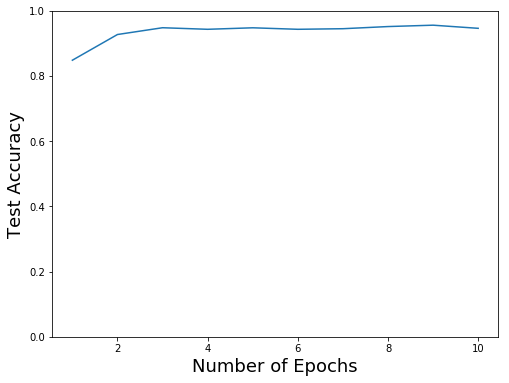

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1, 11), history.acc)
plt.xlabel('Number of Epochs', fontsize=18)
plt.ylabel('Test Accuracy', fontsize=18)
plt.ylim([0,1])
plt.show()